<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-imports-and-dfs" data-toc-modified-id="Load-imports-and-dfs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load imports and dfs</a></span></li><li><span><a href="#Train-model-without-outliers" data-toc-modified-id="Train-model-without-outliers-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train model without outliers</a></span></li><li><span><a href="#Train-model-to-classify-outliers" data-toc-modified-id="Train-model-to-classify-outliers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train model to classify outliers</a></span></li><li><span><a href="#Pick-the-outliers-from-classifed-list-by-sorting" data-toc-modified-id="Pick-the-outliers-from-classifed-list-by-sorting-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pick the outliers from classifed list by sorting</a></span></li><li><span><a href="#Merge-the-outlier-preds-from-best-submission-with-preds-without-outliers" data-toc-modified-id="Merge-the-outlier-preds-from-best-submission-with-preds-without-outliers-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Merge the outlier preds from best submission with preds without outliers</a></span></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 4
%autosave 120

Autosaving every 120 seconds


1. Load imports & test, train DFs
2. Apply stratified kfold & traing with lgbm and submit to kaggle
3. Check for missing data feature engineering parts missed if score > 3.7
4. Split the training set to train & validation
5. Train over RF to get a benchmark of the dataset
6. Drop irrelevant features by sorting on feature importance
7. Drop redundant features by plotting a Dendogram and removing the redundancy
8. Use a feature interpreter to see which feature is contributing lot to prediction
9. Use extrapolation to see if we can remove feature which add bias of training & validation set
10. Use partial dependence plot to see outliers/missed features
11. Submit to kaggle the RF model and see the score
11. Use stratified kfold to train the RF model and submit to kaggle
12. Repeat again with LGBM/XGBoost/Adaboost. Stack the model and submit to kaggle


### Load imports and dfs

In [33]:
from fastai.io import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pandas_summary import DataFrameSummary
from IPython.display import display
from sklearn import metrics
import feather
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, log_loss
import warnings

In [38]:
train_df2 = feather.read_dataframe('train_df')
test_df2 = feather.read_dataframe('test_df')

In [39]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [40]:
df_train_columns = [c for c in train_df2.columns if c not in ['card_id', 'first_active_month','target','outliers']]
target = train_df2['target']

In [41]:
train_df2.shape, test_df2.shape

((201917, 135), (123623, 133))

### Train model without outliers

In [42]:
train_df2 = train_df2.loc[train_df2['outliers'] != 1]

In [43]:
train_df2.shape

(199710, 135)

In [44]:
target = train_df2['target']

In [45]:
del train_df2['target']

In [46]:
len(df_train_columns), target.shape

(131, (199710,))

In [47]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,train_df2['outliers'].values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

np.sqrt(mean_squared_error(oof, target))

fold 0
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 1.59865	valid_1's rmse: 1.62829
[200]	training's rmse: 1.56697	valid_1's rmse: 1.60061
[300]	training's rmse: 1.55215	valid_1's rmse: 1.58965
[400]	training's rmse: 1.54277	valid_1's rmse: 1.5842
[500]	training's rmse: 1.53556	valid_1's rmse: 1.58109
[600]	training's rmse: 1.52941	valid_1's rmse: 1.57919
[700]	training's rmse: 1.52409	valid_1's rmse: 1.578
[800]	training's rmse: 1.5193	valid_1's rmse: 1.57727
[900]	training's rmse: 1.51492	valid_1's rmse: 1.57678
[1000]	training's rmse: 1.51085	valid_1's rmse: 1.57643
[1100]	training's rmse: 1.50695	valid_1's rmse: 1.57612
[1200]	training's rmse: 1.50315	valid_1's rmse: 1.57591
[1300]	training's rmse: 1.4995	valid_1's rmse: 1.57572
[1400]	training's rmse: 1.49591	valid_1's rmse: 1.5756
[1500]	training's rmse: 1.49234	valid_1's rmse: 1.57541
[1600]	training's rmse: 1.48898	valid_1's rmse: 1.57532
[1700]	training's rmse: 1.48549	valid_1's rmse: 1

1.554854386388378

In [48]:
model_without_outliers = pd.DataFrame({"card_id":test_df2["card_id"].values})
model_without_outliers["target"] = predictions

### Train model to classify outliers

In [24]:
train_df2 = feather.read_dataframe('train_df')
test_df2 = feather.read_dataframe('test_df')

In [25]:
target = train_df2['outliers']

In [26]:
for df in [train_df2, test_df2]:
    for f in ['purchase_date_max','purchase_date_min','purchase_date_max_old',\
                     'purchase_date_min_old']:
        df[f] = df[f].astype(np.int64) * 1e-9

In [27]:
del train_df2['outliers']
del train_df2['target']

In [28]:
df_train_columns = [c for c in train_df2.columns 
                    if c not in ['card_id', 'first_active_month','target','outliers']]

In [30]:
categorical_feats = [c for c in df_train_columns if 'feature_' in c]

In [31]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.01,
         "boosting": "rf",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'binary_logloss',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4590}

In [35]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=4590)
oof = np.zeros(len(train_df2))
predictions = np.zeros(len(test_df2))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df2,target.values)):
    print("fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df2.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx],categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train_df2.iloc[val_idx][df_train_columns], label=target.iloc[val_idx],categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(train_df2.iloc[val_idx][df_train_columns], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = df_train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test_df2[df_train_columns], num_iteration=clf.best_iteration) / folds.n_splits

log_loss(target, oof)

fold 0


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0449617	valid_1's binary_logloss: 0.0459191
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.0449114	valid_1's binary_logloss: 0.0458498
fold 1


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0452574	valid_1's binary_logloss: 0.0466596
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0451687	valid_1's binary_logloss: 0.0464814
fold 2


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.045184	valid_1's binary_logloss: 0.0469176
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.04543	valid_1's binary_logloss: 0.0467412
fold 3


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0450062	valid_1's binary_logloss: 0.0473635
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.0449437	valid_1's binary_logloss: 0.0472752
fold 4


/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0444646	valid_1's binary_logloss: 0.0476774
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0444175	valid_1's binary_logloss: 0.0476498


0.04679946742498681

In [36]:
df_outlier_prob = pd.DataFrame({"card_id":test_df2["card_id"].values})
df_outlier_prob["target"] = predictions
df_outlier_prob.head()

,card_id,target
0,C_ID_0ab67a22ab,0.077739
1,C_ID_130fd0cbdd,0.002358
2,C_ID_b709037bc5,0.006890
3,C_ID_d27d835a9f,0.002358
4,C_ID_2b5e3df5c2,0.002358


### Pick the outliers from classifed list by sorting

In [61]:
test_df2.shape, df_outlier_prob.shape

((123623, 133), (123623, 2))

In [104]:
df_outlier_prob.sort_values(by='target',ascending = False).head()

,card_id,target
78078,C_ID_922f9c5ea6,0.472498
35851,C_ID_5ee52cf9f6,0.457334
32446,C_ID_ac114ef831,0.447623
25568,C_ID_767923bdb9,0.446763
90216,C_ID_7d81662584,0.442866


In [105]:
df_outliers_sorted = df_outlier_prob.sort_values(by='target',ascending = False)

In [109]:
(df_outliers_sorted['target'][:25000])

78078     0.472498
35851     0.457334
32446     0.447623
25568     0.446763
90216     0.442866
48945     0.439233
86562     0.427543
33610     0.421394
12446     0.420912
79345     0.419311
61935     0.419260
75740     0.417255
107920    0.416352
77297     0.414817
27384     0.412320
67665     0.410338
21724     0.407771
5008      0.407553
20556     0.407107
5707      0.404124
105394    0.402264
31421     0.401450
17720     0.400033
103851    0.400002
114462    0.394524
31620     0.392646
88190     0.392408
10099     0.392354
63477     0.391815
57626     0.391766
            ...   
110040    0.008235
16390     0.008235
61973     0.008235
7207      0.008235
12643     0.008235
66206     0.008235
110100    0.008235
38602     0.008235
93428     0.008235
3495      0.008235
12576     0.008235
66248     0.008235
110070    0.008235
118743    0.008235
12582     0.008235
61586     0.008235
120580    0.008235
32408     0.008235
71568     0.008235
58852     0.008235
14890     0.008235
26472     0.

In [110]:
df_outliers = pd.DataFrame(df_outliers_sorted[:25000]['card_id'])

/home/chandrasekhar/anaconda3/envs/fastai/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


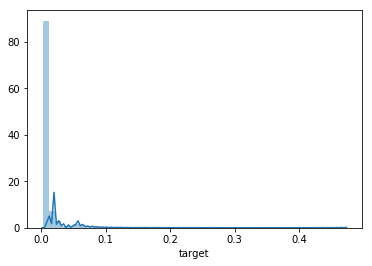

In [73]:
sns.distplot(df_outlier_prob['target'])

In [111]:
df_outliers

,card_id
78078,C_ID_922f9c5ea6
35851,C_ID_5ee52cf9f6
32446,C_ID_ac114ef831
25568,C_ID_767923bdb9
90216,C_ID_7d81662584
48945,C_ID_afbfc01b49
86562,C_ID_24fbe1a353
33610,C_ID_64b13ecfb6
12446,C_ID_b3e1f0a18b
79345,C_ID_63d38cafcb


In [112]:
best_3696 = pd.read_csv('./submission-2019-01-22 10:35:57.465665.csv')

In [113]:
best_3696.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.743338
1,C_ID_130fd0cbdd,-0.395249
2,C_ID_b709037bc5,-0.958020
3,C_ID_d27d835a9f,-0.084196
4,C_ID_2b5e3df5c2,-1.241347


In [114]:
most_likely_liers= best_3696.merge(df_outliers,how='right')

In [115]:
most_likely_liers.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.743338
1,C_ID_f7cada36d3,0.334094
2,C_ID_6d8dba8475,-1.056943
3,C_ID_7f1041e8e1,-4.951848
4,C_ID_22e4a47c72,0.115704


In [116]:
best_3696[best_3696['card_id']=='C_ID_7f1041e8e1']

,card_id,target
14,C_ID_7f1041e8e1,-4.951848


In [117]:
most_likely_liers.shape

(25000, 2)

In [118]:
ix1 = model_without_outliers["card_id"].isin(df_outliers["card_id"].values)
ix2 = best_3696["card_id"].isin(df_outliers["card_id"].values)
model_without_outliers.loc[ix2, "target"] = best_3696[ix1]["target"]

In [119]:
model_without_outliers.shape

(123623, 2)

In [120]:
model_without_outliers.to_csv("combining_submission.csv", index=False)

### Merge the outlier preds from best submission with preds without outliers

In [121]:
FileLink('./combining_submission.csv')

/home/chandrasekhar/private/kaggle/combining_submission.csv